Welcome to BI594 HW #2, due March 24, 2021. We will go over three problems related to logistic bacterial growth and the Lotka-Volterra model of multi-species growth. These problems look long, but a lot of it is stepping through problems slowly, so don't be intimidated. I've noted where particular lecture notes/slides may be useful.

In [1]:
# some needed modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import math
from scipy.stats import linregress
from scipy.linalg import norm
from scipy.integrate import solve_ivp as solve
figsize=(7.5,5)

In [2]:
def get_stationary(x,y,confidence=.05):
    """Performs linear fit to the last phase of growth curves to determine final growth level. 
    (Note to Joe: This is total overkill, im testing something for Caelan's model.)"""
    size = len(x)
    # r_value = 1 always for the initial line which has 2 points
    i=2 # Need at least 2 points to make a line
    next_pt=y.values[size-i]
    while np.abs((next_pt-y.values[size-i])/y.values[size-i]) <= confidence:
        # .loc does same thing as .values but WITH metadata
        slope, intercept, r_value, p_value, std_err = linregress(x.values[size-i:],y.values[size-i:])
        i+=1
    fit_length = i    
    return slope, intercept, r_value, p_value, std_err, fit_length
    

**Problem 1. Total growth vs. total available nutrients**

We saw in class that bacteria typically have an s-shaped growth curve. They begin growing exponentially and as they run out of nutrients, their growth levels off into stationary phase.

Under very low nutrient conditions, sometimes bacterial cultures will exhibit a peak in OD shortly before entering stationary phase. To see an example, execute the code in the cell below. It imports growth data from an experiment I did and plots it.

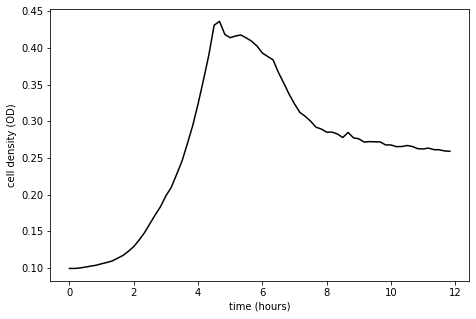

In [3]:
B_subtilis_growth_example = pd.read_csv('https://octagon-seal-xej4.squarespace.com/s/B_sub_growth_example.csv')

plt.figure(figsize=figsize)
plt.xlabel('time (hours)')
plt.ylabel('cell density (OD)')
plt.plot(B_subtilis_growth_example['time_hours'],B_subtilis_growth_example['OD'],'k')
plt.show()

In such an example, you can consider the maximum cell density to be the level in stationary phase (e.g. ~0.25 above), _not_ the maximum at the transient peak. This is because the biomass density in the initial peak was too much for the culture to support, so it cannot be consiered stable. 

I have put another data set of bacterial growth on the course website: https://octagon-seal-xej4.squarespace.com/s/B_sub_glucose_asparagine.csv. It includes _Bacillus subtilis_ growth data in a defined growth medium with glucose as a primary carbon source and asparagine as a primary nitrogen source. The data contains the time axis as well as OD measurements for growth under three mystery nutrient concentrations.

**1(a)** Import the data as a pandas dataframe and plot the growth curves for each condition all on the same graph. Label the x and y axes. You may want to print the data to check the time units, etc.

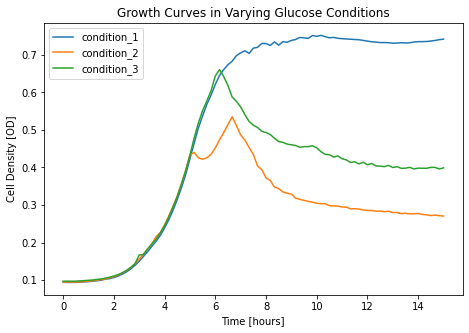

In [4]:
# write code here here.
bsdf = pd.read_csv("https://octagon-seal-xej4.squarespace.com/s/B_sub_glucose_asparagine.csv")
# print(bsdf)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Growth Curves in Varying Glucose Conditions')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cell Density [OD]')
for col in bsdf.columns[1:4]:
    ax.plot(bsdf['time_hours'],bsdf[col],label=col)
ax.legend();

**1(b)** The glucose concentrations were 0.5 g/L, 1.0 g/L, and 5 g/L. Which condition was which concentration and how did you reason this out?

<font color='red'>
    
- Condition 1 $\backsim$ 5.0 [g/L]
- Condition 2 $\backsim$ 0.5 [g/L]
- Condition 3 $\backsim$ 1.0 [g/L]

 Condition 1 exhibits no peak in OD before reaching stationary phase corresponding to a high nutrient concentration. Condition 2 exhibits the lowest OD peak, so it should correspond to the lowest nutrient condition.

**1(c)** For each growth curve, estimate the _total_ growth by subtracting the initial OD from the stationary phase OD. Using your answer from **1(b)**, make a plot of the total growth (y-axis) vs. glucose concentration (x-axis). Make the data points dots of any color you like. 

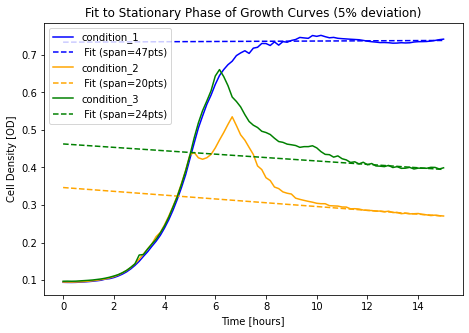

In [5]:
bsdf = pd.read_csv("https://octagon-seal-xej4.squarespace.com/s/B_sub_glucose_asparagine.csv")

colors = {'condition_1':'blue','condition_2':'orange','condition_3':'green'}
t = bsdf['time_hours'].values[:]

fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Fit to Stationary Phase of Growth Curves (5% deviation)')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cell Density [OD]')
for col in bsdf.columns[1:4]:
    ax.plot(bsdf['time_hours'],bsdf[col],label=col,color=colors[col])
    slope, intercept, r_value, p_value, std_err, fit_length = get_stationary(bsdf['time_hours'],bsdf[col])
    ax.plot(t,slope*t+intercept,'--',label= ' Fit (span={})'.format(str(fit_length) + 'pts'),color=colors[col])
ax.legend();

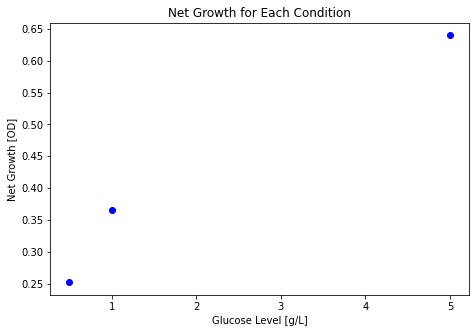

In [6]:
net_grow = {'condition_1':1.0,'condition_2':1.0,'condition_3':1.0}
glucose_conc = {'condition_1':5.0,'condition_2':.5,'condition_3':1.0}

for col in bsdf.columns[1:4]:
    slope, intercept, r_value, p_value, std_err, fit_length = get_stationary(bsdf['time_hours'],bsdf[col])
    net_grow[col]=intercept - bsdf[col].values[0]
# print(net_grow)

fig,ax = plt.subplots(figsize=figsize)
ax.set_title('Net Growth for Each Condition')
ax.set_xlabel('Glucose Level [g/L]')
ax.set_ylabel('Net Growth [OD]')
for col in bsdf.columns[1:4]:
    ax.scatter(glucose_conc[col],net_grow[col],color='blue')

**1(d)** Based on what we discussed in lecture, what do we expect this graph to look like? Does this data appear to fit our expectation based on the results from lecture?

<font color='red'> We expect a more or less linear relationship, and with only three data points this can be easily argued.

**Problem 2. Solving and plotting differential equations in python**

We will go through a couple quick examples inspired by the above data. The in-class code from lecture 8 may be useful here. In problem 1, the doubling time of the bacteria during their exponential phase was roughly 1.2 hours.

**2(a)** How could we have estimated that doubling time?

<font color='red'> We can measure and compare the OD at various points during exponential growth to determine the doubling time.

For the highest growth condition in problem 1, the maximum OD reached is roughly OD = 0.75.

**2(b)** Using the doubling time and maximum OD (called "carrying capacity" in our logistic growth model), write a logistic model equation for this growth (remember the relationship between doubling time, which I gave you and per-capita growth rate $\mu$, which is used in the equation!).

<font color='red'> 
    $\mu = \frac{1}{t_d}*ln(2) \\$
    $\frac{d\rho}{dt}=\mu\rho(1-\frac{\rho}{OD_{max}}) \\$
For $\rho$ the density.

**2(c)**. Define a function called f_logistic that represents in python the right-hand side of your logistic equation.

In [7]:
def f_logistic(t,x,td,ODmax):
    dxdt = (x/td)*np.log(2)*(1-x/ODmax)
    return dxdt

**2(d)** Go through each term of the equation, and describe its biological interpretation (e.g. growth rate of the population, maximum cell density due to nutrient limitation, etc)

<font color='red'> 
   The equation has two terms. The first dominates for a low population, where growth is exponential with the stated doubling time. As population increases more resources are depleted, and so growth saturates the substrate according to the second term. At the point where exponential growth is balanced by the resource depletion term, we have a stable maximum population corresponding to the max OD. 

We would now like to solve the equation for 18 hours of growth.

**2(e)** Define initial and final time points over which to solve your logistic equation for the growth of this culture and create a time axis where python will solve the equation at each point.

In [8]:
t_interval = np.array([0,18])
times = np.linspace(t_interval[0],t_interval[1],1000)

Our initial OD in each case was roughly 0.1.

**2(f)** Create a numpy array that stores this initial condition.

In [9]:
x_0 = np.array([.1])

Now we'll solve the equation.

**2(g)** Import scipy.integrate.solve_ivp to solve this equation and predict the growth of this bacterial culture. Implement solve_ivp by storing the solution in a variable. Remember this solution contains two arrays, the time axis and the y-axis, which will be your predicted OD.

For convenience create two new variables that store these two axes. Remember that the two axes are accessed by adding a .t or .y[0] to the variable where you stored the solution from solve_ivp.

In [10]:
solution = solve(f_logistic,t_interval,x_0,args=(1.2,.75),t_eval=times)
t=solution.t
x=solution.y[0]

**2(h)** Create a graph of the solution with labeled axes.

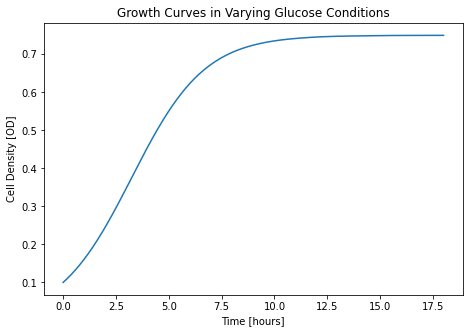

In [11]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Growth Curves in Varying Glucose Conditions')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cell Density [OD]')
ax.plot(t,x)

**2(i)** Compare your graph to the data from problem 1. What features of the data are captured by our model? What is missing?

<font color='red'>  The characteristic S shape, corresponding to an exponential growth regime moving to a stable state is present. However we are missing the characteristic 'overshoot' we saw in some of the data, where the cell population vastly outpaced the available resources, resulting in an unsustainable, unstable peak in the population. We are also missing a clear lag phase near the beginning of growth.

**2(j)** Imagine we are now growing our cells in two different new contidions. In one condition, they double twice as fast, so their doubling time is 0.6 hours, but they grow to the same maximum density of OD=0.75. In the second condition, their doubling time is the same, 1.2 hours, but they grow to twice the maximum density, OD = 1.5. Set up two new functions below to represent growth under these two new conditions and solve them with solve_ivp.

In [12]:
solution_halftd = solve(f_logistic,t_interval,x_0,args=(0.6,.75),t_eval=times)
solution_2OD = solve(f_logistic,t_interval,x_0,args=(1.2,1.5),t_eval=times)

t_halftd=solution_halftd.t
x_halftd=solution_halftd.y[0]

t_2OD=solution_2OD.t
x_2OD=solution_2OD.y[0]

**2(k)** Make two graphs, one plotting the original solution with the fast doubling time solution and the other plotting the original solution with the higher maximum density solution to observe the differences in the model prediction when you change these parameters.

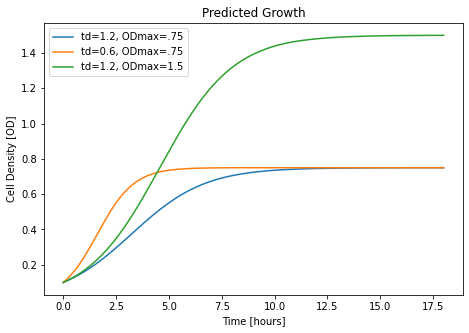

In [13]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Predicted Growth')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cell Density [OD]')
ax.plot(t,x,label='td=1.2, ODmax=.75')
ax.plot(t_halftd,x_halftd,label='td=0.6, ODmax=.75')
ax.plot(t_2OD,x_2OD,label='td=1.2, ODmax=1.5')
ax.legend()

**Problem 3. Conceptualizing a multi-species growth model**

We will step through a few possible scenarios in a Lotka-Volterra model of multi-species growth and answer some conceptual questions.

***Stable coexistence:*** Below I have defined the per-capita growth rates ($\mu_1$,$\mu_2$) and carrying capacities ($K_1$,$K_2$) for two different bacteria. We are measuring cell density in OD, so each $K$ is the maximum OD a species can reach when growing on its own.

In [14]:
# here are the mus and Ks
mu_1_ce = 1.0
mu_2_ce = 3.0

K_1_ce = 2.0
K_2_ce = 2.0

Now we'll define the interaction terms, $\alpha_{12}$ and $\alpha_{21}$.

In [15]:
# here are the alphas
a_12_ce = 0.3
a_21_ce = 0.5

The Lotka-Volterra model predicts the growth dynamics of these species based on these the above parameters. For this system, the equations are:

<br /><center>\begin{equation}\frac{dn_{1}}{dt} = \frac{r_{1}}{K_{1}}n_{1}(K_{1}-n_{1}-\alpha_{12}n_{2})\end{equation} \begin{equation}\frac{dn_{2}}{dt} = \frac{r_{2}}{K_{2}}n_{2}(K_{2}-n_{2}-\alpha_{21}n_{1})\end{equation}</center><br />

We saw in lecture that the parentheses term defines a line where each species has zero growth. These lines are called "nullclines" of the model, and the tell us a lot about how the system will evolve in time. 

**3(a)** Create a figure below that plots the nullcline lines for each species based on the parameters I've given above. Lecture 9 may be helpful here.

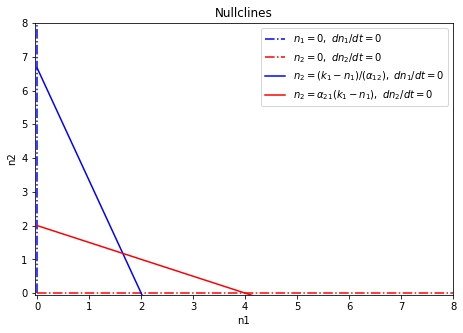

In [16]:
axis = np.linspace(0,10,100)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Nullclines')
ax.set_xlabel('n1')
ax.set_ylabel('n2')
ax.plot(0*axis,axis,'-.',label=r'$n_1=0,\ dn_1/dt=0$',color='blue')
ax.plot(axis,0*axis,'-.',label=r'$n_2=0,\ dn_2/dt=0$',color='red')
ax.plot(axis,(K_1_ce-axis)/a_12_ce,label=r'$n_2=(k_1-n_1)/(\alpha_{12}),\ dn_1/dt=0$',color='blue')
ax.plot(axis,K_2_ce-axis*a_21_ce,label=r'$n_2=\alpha_{21}(k_1-n_1),\ dn_2/dt=0$',color='red')
ax.set_ylim(-.05,8)
ax.set_xlim(-.05,8)
ax.legend();

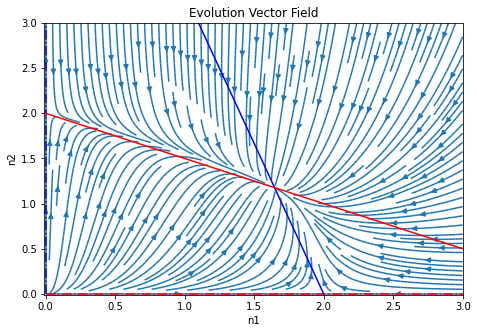

In [23]:
axis = np.linspace(0,3,1000)
X,Y = np.meshgrid(axis,axis)
Vx,Vy =  (mu_1_ce/K_1_ce)*X*(K_1_ce-X-a_12_ce*Y),(mu_2_ce/K_2_ce)*Y*(K_2_ce-Y-a_21_ce*X)

fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Evolution Vector Field')
ax.set_xlabel('n1')
ax.set_ylabel('n2')
ax.plot(0*axis,axis,'-.',label=r'$n_1=0,\ dn_1/dt=0$',color='blue')
ax.plot(axis,0*axis,'-.',label=r'$n_2=0,\ dn_2/dt=0$',color='red')
ax.plot(axis,(K_1_ce-axis)/a_12_ce,label=r'$n_2=(k_1-n_1)/(\alpha_{12}),\ dn_1/dt=0$',color='blue')
ax.plot(axis,K_2_ce-axis*a_21_ce,label=r'$n_2=\alpha_{21}(k_1-n_1),\ dn_2/dt=0$',color='red')
Q=ax.streamplot(X[::3,::3],Y[::3,::3],Vx[::3,::3],Vy[::3,::3],density=2)
ax.set_ylim(-.01,3)
ax.set_xlim(-.01,3);
# ax.legend();

**3(b)** We innoculate the system with an OD of 0.2 for species 1 and 1.2 for species 2. Based off of your graph from **3(a)**, what will be the ODs for species 1 and species 2 that this system will evolve toward?

<font color='red'> The species will evolve towards the point where $\frac{dn_1}{dt}=\frac{dn_2}{dt}=0$, this corresponds to the point;

In [25]:
x_intersect = ((K_1_ce-K_2_ce*a_12_ce)/(1-a_12_ce*a_21_ce))
y_intersect = (1/a_12_ce)*(K_1_ce-x_intersect)
print('Intersection(n1 n2) = (',x_intersect,y_intersect,')')

Intersection(n1 n2) = ( 1.6470588235294117 1.1764705882352944 )


**3(c)** What will be the finals ODs for each species if instead we innoculated with 1.5 OD of species 1 and 0.1 OD of species 2?

<font color='red'> The system will still evolve towards the same point in n1,n2.

**3(d)** Is there any point in our model system with non-zero ODs for the two species that will not evolve toward the pair of species densities you identified in the previous questions?

<font color='red'> If we innoculate with non-zero initial OD's, the system will always evolve towards the point where there is a stable population of both n1 and n2;

***Bistability:*** We now have a system with a slightly different set of growth and competition parameters given below.

In [26]:
# here are the mus, Ks, and alphas
mu_1_bs = 1.0
mu_2_bs = 3.0

K_1_bs = 2.0
K_2_bs = 2.0

a_12_bs = 1.6
a_21_bs = 1.9

**3(e)** Create another figure that plots the nullclines for this set of growth and competition parameters in the Lotka-Volterra model.

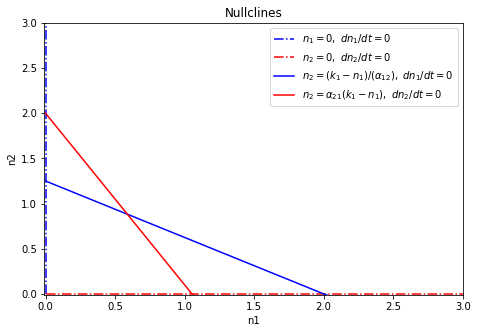

In [27]:
axis = np.linspace(0,10,1000)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Nullclines')
ax.set_xlabel('n1')
ax.set_ylabel('n2')
ax.plot(0*axis,axis,'-.',label=r'$n_1=0,\ dn_1/dt=0$',color='blue')
ax.plot(axis,0*axis,'-.',label=r'$n_2=0,\ dn_2/dt=0$',color='red')
ax.plot(axis,(K_1_bs-axis)/a_12_bs,label=r'$n_2=(k_1-n_1)/(\alpha_{12}),\ dn_1/dt=0$',color='blue')
ax.plot(axis,K_2_bs-axis*a_21_bs,label=r'$n_2=\alpha_{21}(k_1-n_1),\ dn_2/dt=0$',color='red')
ax.set_ylim(-.01,3)
ax.set_xlim(-.01,3)
ax.legend();

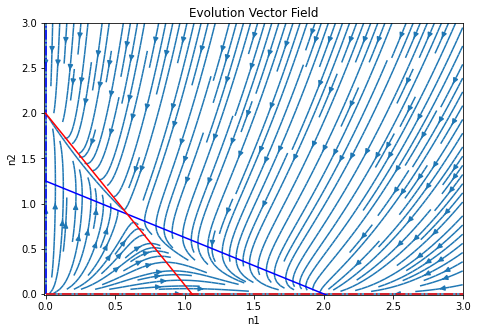

In [40]:
axis = np.linspace(0,3,1000)
X,Y = np.meshgrid(axis,axis)
Vx,Vy =  (mu_1_bs/K_1_bs)*X*(K_1_bs-X-a_12_bs*Y),(mu_2_bs/K_2_bs)*Y*(K_2_bs-Y-a_21_bs*X)

fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Evolution Vector Field')
ax.set_xlabel('n1')
ax.set_ylabel('n2')
ax.plot(0*axis,axis,'-.',label=r'$n_1=0,\ dn_1/dt=0$',color='blue')
ax.plot(axis,0*axis,'-.',label=r'$n_2=0,\ dn_2/dt=0$',color='red')
ax.plot(axis,(K_1_bs-axis)/a_12_bs,label=r'$n_2=(k_1-n_1)/(\alpha_{12}),\ dn_1/dt=0$',color='blue')
ax.plot(axis,K_2_bs-axis*a_21_bs,label=r'$n_2=\alpha_{21}(k_1-n_1),\ dn_2/dt=0$',color='red')
Q=ax.streamplot(X[::3,::3],Y[::3,::3],Vx[::3,::3],Vy[::3,::3],density=2)
ax.set_ylim(-.01,3)
ax.set_xlim(-.01,3);
# ax.legend();

**3(f)** We innoculate the system with an OD of 0.1 of species 1 and 0.75 of species 2. What pair of ODs for species 1 and species 2 does the model predict the system will evolve towards? Lecture 10 may help with this.

<font color='red'> The system should tend towards the point (n1,n2)=(0.0,2.0)

**3(g)** Now we innoculate the system with an OD of 0.9 of species 1 and 0.2 of species 2. Based on your phase plot, what pair of ODs for species 1 and species 2 does the model predict the system will evolve towards now?

<font color='red'> The system should tend towards the point (n1,n2)=(2.0,0.0)

**3(h)** What is different about this scenario in our model compared to the stable coexistence example? Based on the different parameter values for the coexistence example and this one, describe how the model mathemetically represents the different ecological scenarios it's modeling.

<font color='red'>  In this scenario there is no stable coexistence state, and all initial states must tend towards a steady state where either one or the other species dominates. We see then that for alpha<1 we get coexistence models, and for alpha>1 we get competition models. 